[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1K0l8p9SKZILaqlCnpBKghoP2p4fnAKJ1#scrollTo=AbzOJtExoRSb)

# Imports

In [ ]:
!pip install pywaffle

In [38]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import numpy as np
import plotly.graph_objects as go

from ast import literal_eval
from statistics import mean
from matplotlib import pyplot as plt
from google.colab import files
from collections import Counter
from pywaffle import Waffle


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:20,.2f}'.format

# Helper Code

In [2]:
def unpack_interests(x):
    if pd.isna(x) == False:
        return [i["name"] for i in literal_eval(x)] # only one example where there are multiple and both are conceptually the same

    else:
        return None


def calc_proporations(row, field, df_total):
    return round((row[field] / df_total[df_total["page_owner_name"]==row["page_owner_name"]][field]).values[0], 2)


def distribution_comparer(df, comparison_field: str, metric_field: str):

    for i in df[comparison_field].unique():

        temp_df = df[df[comparison_field] == i]
        biden = temp_df.query("page_owner_name == 'Biden'")[metric_field]
        trump = temp_df.query("page_owner_name == 'Trump'")[metric_field]

        tstat, pval = stats.mannwhitneyu(biden, trump, alternative='two-sided')

        print(f"-----({i})-----")
        print(f"Biden Median {metric_field}: {biden.median()}")
        print(f"Trump Median {metric_field}: {trump.median()}")
        print(f"Mann-Whitney U stat: {tstat}")
        print(f"p-value: {pval}")
        print()

def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList


def label(x, color, label):
    ax = plt.gca()
    ax.text(-.1, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)

# Load Data

In [7]:
files.upload()

Saving data.csv to data.csv


In [ ]:
df = pd.read_parquet("data.parquet").drop_duplicates()
df["page_owner_name"] = df["page_owner"].map({153080620724: "Trump", 7860876103: "Biden"})
df["interests"] = df["interests"].map(lambda x: unpack_interests(x))

In [ ]:
df.shape

(407706, 10)

In [ ]:
df["archive_id"].drop_duplicates().shape

(376918,)

In [ ]:
df[["archive_id", "waist_ui_type"]].dropna(subset=["waist_ui_type"]).drop_duplicates("archive_id").shape

(30, 2)

In [ ]:
df.isna().sum()

archive_id                     0
page_owner                     0
ad_creative_body           17365
ad_delivery_start_time         0
ad_type                      177
topic_name                     0
description               414261
interests                 413559
waist_ui_type             404073
impressions                    0
spend                          0
page_owner_name                0
dtype: int64

# Top Spenders: Overall

In [ ]:
df_total = df[["archive_id", "page_owner_name", "spend", "impressions"]] \
            .drop_duplicates(subset=["archive_id"]) \
            .groupby(["page_owner_name"]) \
            .agg({'archive_id': "count", 'spend': sum, "impressions": sum,}) \
            .rename(columns={"archive_id": "counts"}) \
            .sort_values(by="spend", ascending=False) \
            .reset_index()
df_total["Impressions per Dollar"] = df_total["impressions"] / df_total["spend"]

In [11]:
df_total

,page_owner_name,counts,spend,impressions,Impressions per Dollar
0,Biden,76532,"100,902,625.67",2319982500,22.99
1,Trump,300386,"34,980,242.98",2457371500,70.25


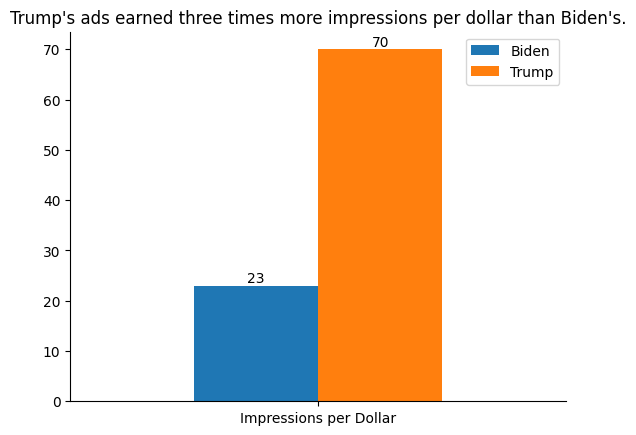

In [12]:
temp_df = df_total.set_index("page_owner_name")[["Impressions per Dollar"]].round()
temp_df.index.name = None
ax = temp_df.T.plot(kind='bar', rot=0,
              title="Trump's ads earned three times more impressions per dollar than Biden's.")
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [13]:
print(df.drop_duplicates(subset=["archive_id"]).query("page_owner_name == 'Biden'")["spend"].median())
print(df.drop_duplicates(subset=["archive_id"]).query("page_owner_name == 'Trump'")["spend"].median())

20.14
1.5


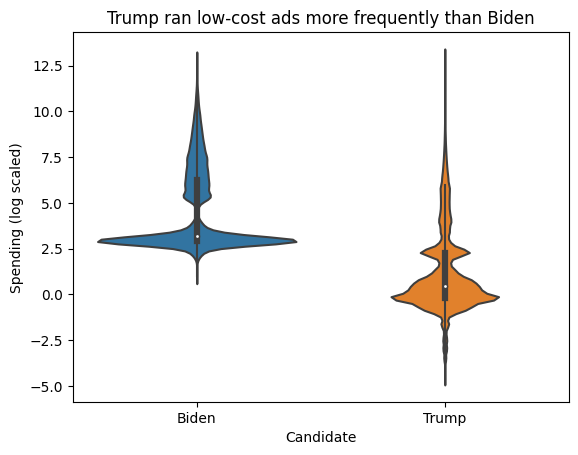

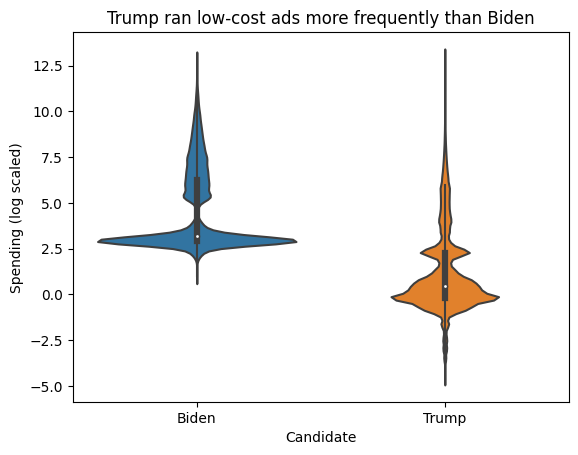

In [17]:
temp_df = df.copy()
temp_df["spend"] = np.log(temp_df["spend"])

plot = sns.violinplot(
    data=temp_df,
    x="page_owner_name",
    y="spend",
    )

plt.title('Trump ran low-cost ads more frequently than Biden')
plt.xlabel("Candidate",)
plt.ylabel("Spending (log scaled)")

plot.get_figure()

Text(0.5, 0.98, 'Trump ran low-spend ads more frequently than Biden.')

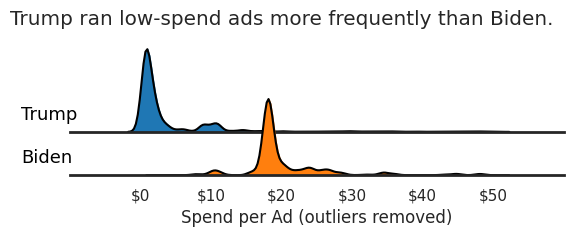

In [19]:
temp_df = df.copy()
temp_df = temp_df[Remove_Outlier_Indices(temp_df["spend"])]

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("tab10", 12)

g = sns.FacetGrid(temp_df, palette=palette, row="page_owner_name", hue="page_owner_name", aspect=5, height=1.2)
g.map_dataframe(sns.kdeplot, x="spend", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="spend", color='black')


g.map(label, "page_owner_name")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="Spend per Ad (outliers removed)",)
g.despine(left=True)
g.set_xticklabels(["", "$0", "$10", "$20", "$30", "$40", "$50", ""])


plt.suptitle('Trump ran low-spend ads more frequently than Biden.', y=0.98)

[Text(0, 0, '1.5')]

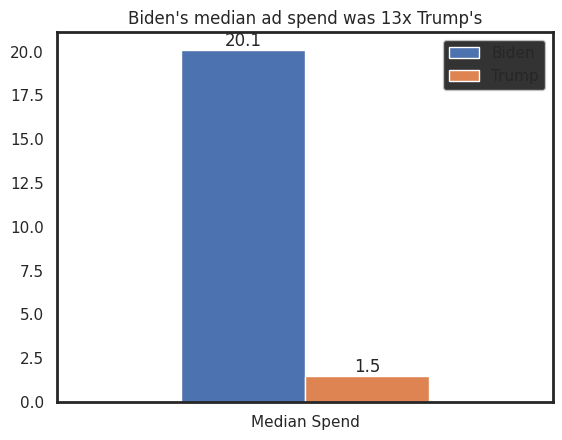

In [21]:
temp_df = pd.DataFrame({
    "Median Spend": {
    "Biden": df.drop_duplicates(subset=["archive_id"]).query("page_owner_name == 'Biden'")["spend"].median(),
    "Trump": df.drop_duplicates(subset=["archive_id"]).query("page_owner_name == 'Trump'")["spend"].median(),
    }}).round(1)
temp_df.index.name = None
ax = temp_df.T.plot(kind='bar', rot=0,
              title="Biden's median ad spend was 13x Trump's")
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')

In [22]:
df_total.set_index("page_owner_name")[["Impressions per Dollar"]].round()

,Impressions per Dollar
page_owner_name,
Biden,23.00
Trump,70.00


## Spend by waist_ui_type

In [25]:
biden_interests = Counter()
trump_interests = Counter()


for candidate, interest_set in zip(df["page_owner_name"], df["interests"]):

    if interest_set:

        if candidate == "Biden":
            biden_interests.update(interest_set)

        elif candidate == "Trump":
            trump_interests.update(interest_set)


In [26]:
biden_interests.most_common(20)

[('Elizabeth Warren', 136),
 ('Bernie Sanders', 130),
 ('Barack Obama', 58),
 ('NPR', 46),
 ('U.S. Senator Bernie Sanders', 38),
 ('U.S. Senator Elizabeth Warren', 38),
 ('Southern Poverty Law Center', 37),
 ('Democratic Governors Association', 24),
 ('Supreme Court of the United States', 24),
 ("EMILY's List", 23),
 ('Cory Booker', 18),
 ('Michelle Obama', 16),
 ('Kamala Harris', 11),
 ('Democratic Party (United States)', 11),
 ('Jay Inslee', 11),
 ('Complex (magazine)', 10),
 ('NPR All Things Considered', 9),
 ('Oprah Winfrey', 9),
 ('George Takei', 9),
 ('Joe Biden', 8)]

In [27]:
trump_interests.most_common(20)

[('Ben Shapiro', 89),
 ('National Rifle Association', 80),
 ('ForAmerica', 46),
 ('Ultimate Fighting Championship', 45),
 ('Mark Levin', 33),
 ('The Daily Caller', 32),
 ("Cabela's", 31),
 ('Duluth Trading Company', 30),
 ('Ted Cruz', 29),
 ('Allen West (politician)', 29),
 ('Sean Hannity', 28),
 ('Green Bay Packers', 24),
 ("Bill O'Reilly (political commentator)", 22),
 ('Rush Limbaugh', 22),
 ('100 Percent FED Up', 21),
 ('Barstool Sports', 20),
 ('Steven Crowder', 20),
 ('Gun Owners of America', 20),
 ('Tucker Carlson', 19),
 ('Ted Nugent', 18)]

In [28]:
df_total_targeting = df[["archive_id", "page_owner_name", "waist_ui_type", "spend", "impressions"]] \
            .drop_duplicates(subset=["archive_id"]) \
            .groupby(["page_owner_name", "waist_ui_type"]) \
            .agg({'archive_id': "count", 'spend': sum, "impressions": sum}) \
            .rename(columns={"archive_id": "counts"}) \
            .sort_values(by=["waist_ui_type", "spend"], ascending=False) \
            .reset_index()

In [29]:
df_total_targeting

,page_owner_name,waist_ui_type,counts,spend,impressions
0,Biden,LOCATION,37,"758,738.10",12846500
1,Trump,LOCATION,9,"7,784.90",1862000
2,Biden,INTERESTS,205,"1,219,318.48",38138500
3,Trump,INTERESTS,78,"540,068.63",30538500
4,Biden,FRIENDS_OF_CONNECTION,73,"861,962.58",18850500
5,Biden,CUSTOM_AUDIENCES_WEBSITE,10,"203,122.74",2548000
6,Trump,CUSTOM_AUDIENCES_WEBSITE,44,"32,651.82",2974000
7,Biden,CUSTOM_AUDIENCES_LOOKALIKE,465,"2,373,922.57",62482500
8,Trump,CUSTOM_AUDIENCES_LOOKALIKE,129,"109,670.38",28265000
9,Biden,CUSTOM_AUDIENCES_ENGAGEMENT_VIDEO,10,"46,689.76",1112000


# Top Spenders: By Topic

In [30]:
exclude_topics = ["Uncategorized", "Ukraine", "Donation", "Election"]

df_by_topic = df[["archive_id", "page_owner_name", "topic_name", "spend", "impressions"]] \
            .groupby(["page_owner_name", "topic_name"]) \
            .agg({'archive_id': "count", 'spend': sum, "impressions": sum}) \
            .rename(columns={"archive_id": "counts"}) \
            .query("topic_name not in @exclude_topics") \
            .sort_values(by=["topic_name", "spend"], ascending=False) \
            .reset_index()


df_by_topic["average_spend"] = df_by_topic["spend"] / df_by_topic["counts"]
df_by_topic["proportional_spend"] = df_by_topic.apply(lambda row: calc_proporations(row, "spend", df_total), axis=1)
df_by_topic["average_impressions"] = df_by_topic["impressions"] / df_by_topic["counts"]
df_by_topic["proportional_impressions"] = df_by_topic.apply(lambda row: calc_proporations(row, "impressions", df_total), axis=1)

In [31]:
df_by_topic

,page_owner_name,topic_name,counts,spend,impressions,average_spend,proportional_spend,average_impressions,proportional_impressions
0,Biden,Trump,12543,"23,557,590.83",540650000,"1,878.15",0.23,"43,103.72",0.23
1,Trump,Trump,1729,"74,317.84",11717000,42.98,0.00,"6,776.75",0.00
2,Biden,Military,403,"174,531.12",3667000,433.08,0.00,"9,099.26",0.00
3,Trump,Military,209,"7,966.13",1851000,38.12,0.00,"8,856.46",0.00
4,Trump,Law Enforcement,10308,"1,089,420.17",65259500,105.69,0.03,"6,330.96",0.03
5,Biden,Law Enforcement,726,"19,337.79",510500,26.64,0.00,703.17,0.00
6,Trump,Judicial Branch,9977,"1,802,350.66",225307500,180.65,0.05,"22,582.69",0.09
7,Biden,Judicial Branch,739,"1,341,233.26",44191500,"1,814.93",0.01,"59,799.05",0.02
8,Biden,Immigration,113,"204,187.15",7242500,"1,806.97",0.00,"64,092.92",0.00
9,Trump,Immigration,4325,"106,956.28",16625500,24.73,0.00,"3,844.05",0.01


<AxesSubplot: xlabel='page_owner_name', ylabel='spend'>

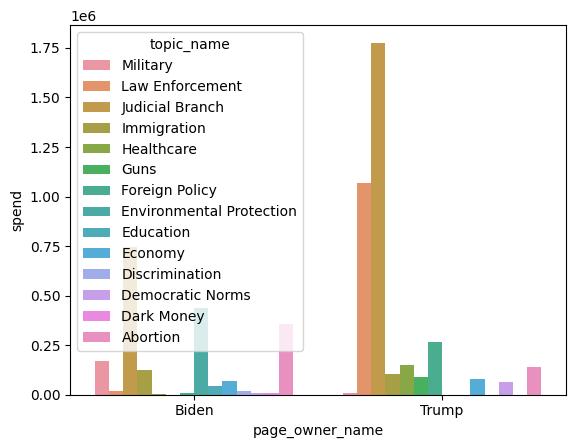

In [ ]:
sns.barplot(data=df_by_topic, x="page_owner_name", y="spend", hue="topic_name", orient="v")

In [ ]:
df_by_topic_pivot = df_by_topic.pivot(index='topic_name', columns='page_owner_name', values=["counts", "spend", "impressions"]).fillna(0)
df_by_topic_pivot

counts                       \
page_owner_name                         Biden                Trump   
topic_name                                                           
Abortion                               183.00               219.00   
Dark Money                              79.00                 0.00   
Democratic Norms                         5.00               199.00   
Discrimination                           5.00                 0.00   
Economy                                 16.00               508.00   
Education                              105.00                 0.00   
Environmental Protection               509.00                 4.00   
Foreign Policy                          84.00             3,259.00   
Guns                                     0.00             2,055.00   
Healthcare                               7.00             2,717.00   
Immigration                             98.00             4,319.00   
Judicial Branch                        666.00             9,931.00   
Law Enforcement                        726.00            10,282.00   
Military                               400.00               208.00   
Trump                               11,630.00             1,717.00   

                                        spend                       \
page_owner_name                         Biden                Trump   
topic_name                                                           
Abortion                           355,858.73           140,495.25   
Dark Money                           6,848.96                 0.00   
Democratic Norms                     6,349.43            63,180.72   
Discrimination                      19,456.90                 0.00   
Economy                             69,083.08            79,913.72   
Education                           41,749.64                 0.00   
Environmental Protection           435,888.86                59.69   
Foreign Policy                       9,536.18           265,941.60   
Guns                                     0.00            90,035.49   
Healthcare                           6,003.66           148,286.76   
Immigration                        122,439.18           103,769.54   
Judicial Branch                    743,980.69         1,776,149.35   
Law Enforcement                     19,337.79         1,067,568.31   
Military                           171,164.37             6,342.34   
Trump                           14,503,157.96            68,933.98   

                                  impressions                       
page_owner_name                         Biden                Trump  
topic_name                                                          
Abortion                         9,542,500.00         3,222,500.00  
Dark Money                         317,500.00                 0.00  
Democratic Norms                    57,500.00         7,017,500.00  
Discrimination                     185,000.00                 0.00  
Economy                            782,500.00         6,126,500.00  
Education                          836,000.00                 0.00  
Environmental Protection         8,684,000.00            12,000.00  
Foreign Policy                     233,500.00        29,858,000.00  
Guns                                     0.00        14,701,000.00  
Healthcare                         410,000.00        12,282,000.00  
Immigration                      4,241,000.00        15,855,500.00  
Judicial Branch                 26,286,500.00       216,253,000.00  
Law Enforcement                    510,500.00        61,719,500.00  
Military                         3,559,500.00         1,476,000.00  
Trump                          347,174,500.00        11,107,000.00

In [35]:

fig = go.Figure(data=[go.Table(
    header=dict(values=[("", "Topics"), ("Counts", "Biden"), ("Counts", "Trump"), ("Spend", "Biden"), ("Spend", "Trump"), ("Impressions", "Biden"), ("Impressions", "Trump")],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[
        df_by_topic_pivot.index,
        df_by_topic_pivot.counts.Biden, df_by_topic_pivot.counts.Trump,
        df_by_topic_pivot.spend.Biden, df_by_topic_pivot.spend.Trump,
        df_by_topic_pivot.impressions.Biden, df_by_topic_pivot.impressions.Trump,
          ],
    fill_color='lavender',
    align='left'))
])

fig.show()

# Top Spenders: By Type

In [ ]:
df.query("page_owner_name == 'Biden'")["ad_type"].value_counts()

Donate      54830
Connect     19823
Unknown     13609
Show Up      7827
Persuade     2608
Buy           145
Name: ad_type, dtype: int64

In [ ]:
df_by_type = df[["archive_id", "page_owner_name", "ad_type", "spend", "impressions"]] \
            .drop_duplicates(subset=["archive_id"]) \
            .groupby(["page_owner_name", "ad_type"]) \
            .agg({'archive_id': "count", 'spend': sum,"impressions": sum}) \
            .rename(columns={"archive_id": "counts"}) \
            .query("ad_type != 'Unknown'") \
            .sort_values(by=["ad_type", "spend"], ascending=False) \
            .reset_index()

df_by_type["average_spend"] = df_by_type["spend"] / df_by_type["counts"]
df_by_type["proportional_spend"] = df_by_type.apply(lambda row: calc_proporations(row, "spend", df_total), axis=1)
df_by_type["average_impressions"] = df_by_type["impressions"] / df_by_type["counts"]
df_by_type["proportional_impressions"] = df_by_type.apply(lambda row: calc_proporations(row, "impressions", df_total), axis=1)

In [ ]:
df_by_type

,page_owner_name,ad_type,counts,spend,impressions,average_spend,proportional_spend,average_impressions,proportional_impressions
0,Trump,Show Up,124573,"6,808,911.56",686111500,54.66,0.19,"5,507.71",0.28
1,Biden,Show Up,7732,"4,543,807.20",150108500,587.66,0.05,"19,413.93",0.06
2,Biden,Persuade,2482,"3,687,469.66",64162000,"1,485.68",0.04,"25,850.93",0.03
3,Trump,Persuade,6934,"256,107.43",41536500,36.94,0.01,"5,990.27",0.02
4,Biden,Donate,34674,"43,554,213.75",1038765000,"1,256.11",0.43,"29,958.04",0.45
5,Trump,Donate,162952,"27,434,422.68",1638591000,168.36,0.78,"10,055.67",0.67
6,Biden,Connect,17944,"12,284,478.08",278578000,684.60,0.12,"15,524.86",0.12
7,Trump,Connect,2554,"298,528.55",36404000,116.89,0.01,"14,253.72",0.01
8,Biden,Buy,139,"744,516.90",10123500,"5,356.24",0.01,"72,830.94",0.00
9,Trump,Buy,3373,"182,272.76",54728500,54.04,0.01,"16,225.47",0.02


In [ ]:
df_by_type_pivot = df_by_type.pivot(index='ad_type', columns='page_owner_name', values=["counts", "spend", "impressions"])
df_by_type_pivot

counts                       \
page_owner_name                Biden                Trump   
ad_type                                                     
Buy                           139.00             3,373.00   
Connect                    17,944.00             2,554.00   
Donate                     34,674.00           162,952.00   
Persuade                    2,482.00             6,934.00   
Show Up                     7,732.00           124,573.00   

                               spend                       \
page_owner_name                Biden                Trump   
ad_type                                                     
Buy                       744,516.90           182,272.76   
Connect                12,284,478.08           298,528.55   
Donate                 43,554,213.75        27,434,422.68   
Persuade                3,687,469.66           256,107.43   
Show Up                 4,543,807.20         6,808,911.56   

                         impressions                       
page_owner_name                Biden                Trump  
ad_type                                                    
Buy                    10,123,500.00        54,728,500.00  
Connect               278,578,000.00        36,404,000.00  
Donate              1,038,765,000.00     1,638,591,000.00  
Persuade               64,162,000.00        41,536,500.00  
Show Up               150,108,500.00       686,111,500.00

In [ ]:
df_by_type_pivot["impressions"].loc["Donate"]

page_owner_name
Biden       1,038,765,000.00
Trump       1,638,591,000.00
Name: Donate, dtype: float64

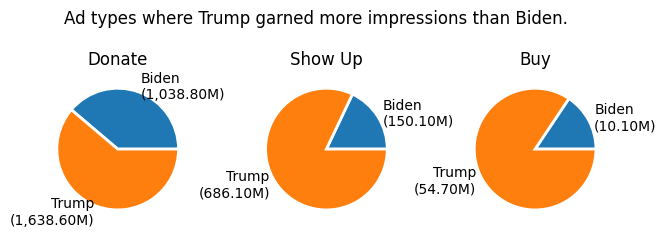

In [ ]:
fig, axes = plt.subplots(1, 3)
fig.tight_layout(pad=1.0)
names = df_by_type_pivot["impressions"].columns

fig.suptitle('Ad types where Trump garned more impressions than Biden.')
fig.subplots_adjust(top=1.3)

for i, ad_type in enumerate(["Donate", "Show Up", "Buy"]):

    values = list(df_by_type_pivot["impressions"].loc[ad_type].values)

    axes[i].pie(
        values,
        labels=[f"{name}\n({'{0:,.2f}'.format(round(value/1000000, 1))}M)" for name, value in zip(names, values)],
        wedgeprops = {'linewidth' : 2, 'edgecolor' : 'white'},
    )
    axes[i].title.set_text(ad_type)


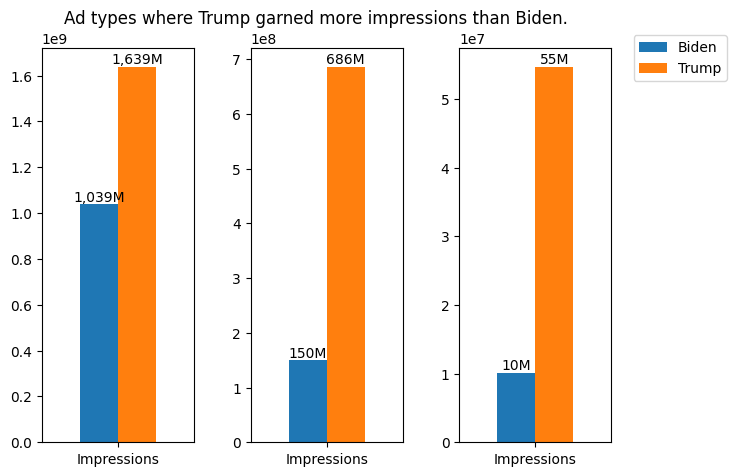

In [ ]:
fig, axes = plt.subplots(1, 3)
fig.tight_layout(pad=1.0)
names = df_by_type_pivot["impressions"].columns

fig.suptitle('Ad types where Trump garned more impressions than Biden.')
fig.subplots_adjust(top=.9)

for i, ad_type in enumerate(["Donate", "Show Up", "Buy"]):

    biden = df_by_type_pivot["impressions"].loc[ad_type]["Biden"]
    trump = df_by_type_pivot["impressions"].loc[ad_type]["Trump"]

    temp_df = pd.DataFrame({
        "Impressions": {
        "Biden": biden,
        "Trump": trump,
        }})
    temp_df.index.name = None
    ax = temp_df.T.plot(kind='bar', rot=0, ax=axes[i], legend=False)

    bars = ax.containers[0]
    axes[i].bar_label(bars, labels = [f"{round(x.get_height()/1000000, 1):,.0f}M" for x in bars])

    bars = ax.containers[1]
    axes[i].bar_label(bars, labels = [f"{round(x.get_height()/1000000, 1):,.0f}M" for x in bars])


    if i==2:
        ax.legend(bbox_to_anchor=(1.1, 1.05))

In [ ]:
df_by_type_pivot = df_by_type.pivot(index='ad_type', columns='page_owner_name', values=["proportional_spend","proportional_impressions"])
df_by_type_pivot

proportional_spend                       \
page_owner_name                Biden                Trump   
ad_type                                                     
Buy                             0.01                 0.01   
Connect                         0.12                 0.01   
Donate                          0.43                 0.78   
Persuade                        0.04                 0.01   
Show Up                         0.05                 0.19   

                proportional_impressions                       
page_owner_name                    Biden                Trump  
ad_type                                                        
Buy                                 0.00                 0.02  
Connect                             0.12                 0.01  
Donate                              0.45                 0.67  
Persuade                            0.03                 0.02  
Show Up                             0.06                 0.28

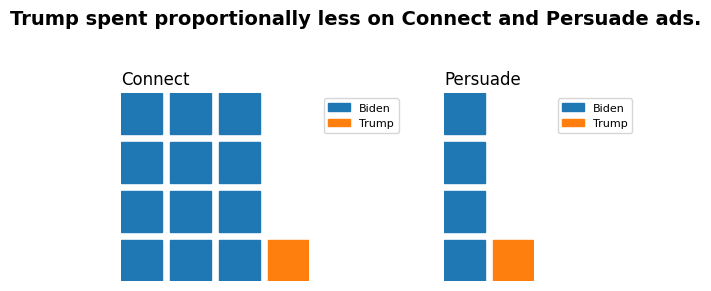

In [ ]:
temp_df = df_by_type_pivot["proportional_spend"]

fig = plt.figure(
    FigureClass=Waffle,
    plots={
        211: {
            'values': list(100*temp_df.loc["Connect"].values),
            'labels': list(temp_df.columns),
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'Connect', 'loc': 'left', 'fontsize': 12}
        },
        233: {
            'values': list(100*temp_df.loc["Persuade"].values),
            'labels': list(temp_df.columns),
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.2, 1), 'fontsize': 8},
            'title': {'label': 'Persuade', 'loc': 'left', 'fontsize': 12}
        },
    },
    rows=4,
    cmap_name="tab10",
    rounding_rule='ceil',
    figsize=(5, 5)
)

fig.suptitle('Trump spent proportionally less on Connect and Persuade ads.', fontsize=14, fontweight='bold')

In [ ]:
log_df = df.query("ad_type != 'Unknown'").copy()
log_df["spend"] = np.log(log_df["spend"])
log_df["impressions"] = np.log(log_df["impressions"])

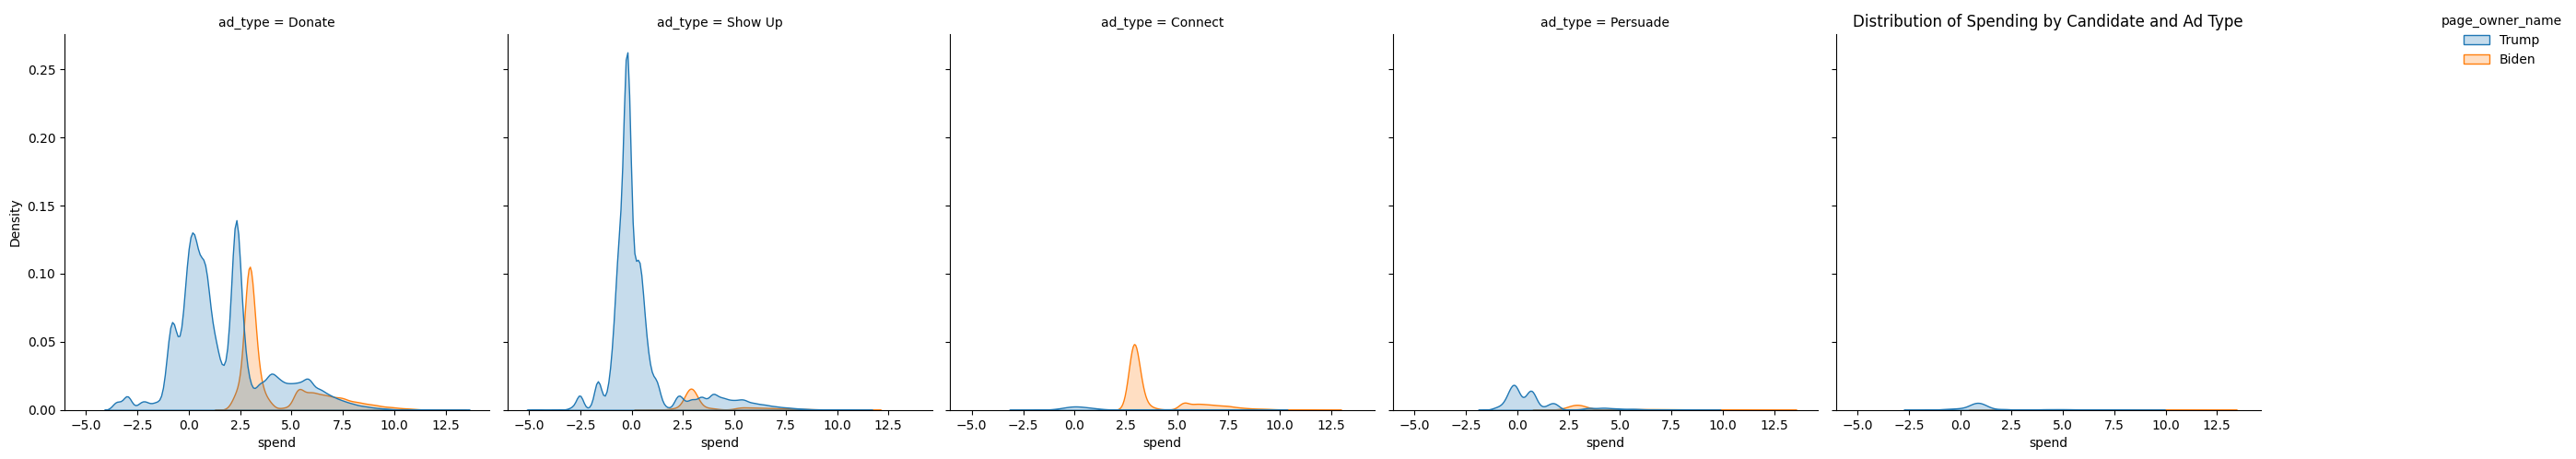

In [ ]:
plot = sns.displot(
    data=log_df,
    x='spend',
    hue='page_owner_name',
    col='ad_type',
    kind='kde',
    fill=True,
)


plt.title('Distribution of Spending by Candidate and Ad Type')

sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

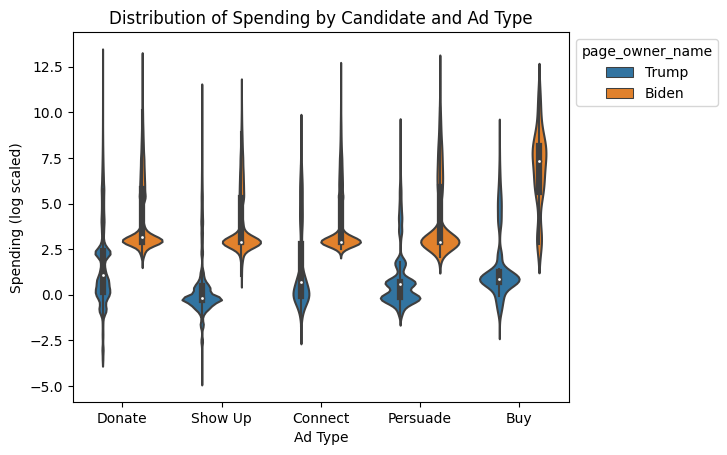

In [ ]:
plot = sns.violinplot(
    data=log_df,
    x="ad_type",
    y="spend",
    hue="page_owner_name"
    )

plt.title('Distribution of Spending by Candidate and Ad Type')
plt.xlabel("Ad Type",)
plt.ylabel("Spending (log scaled)")

sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
distribution_comparer(
    df=df.query("ad_type != 'Unknown'").dropna(subset="ad_type"),
    comparison_field= "ad_type",
    metric_field= "spend",
)

-----(Donate)-----
Biden Median spend: 23.19
Trump Median spend: 2.97
Mann-Whitney U stat: 7272848486.5
p-value: 0.0

-----(Show Up)-----
Biden Median spend: 18.1
Trump Median spend: 0.82
Mann-Whitney U stat: 889100388.0
p-value: 0.0

-----(Connect)-----
Biden Median spend: 18.32
Trump Median spend: 2.04
Mann-Whitney U stat: 39945169.5
p-value: 0.0

-----(Persuade)-----
Biden Median spend: 18.32
Trump Median spend: 1.77
Mann-Whitney U stat: 29078482.0
p-value: 0.0

-----(Buy)-----
Biden Median spend: 1541.61
Trump Median spend: 2.34
Mann-Whitney U stat: 452140.0
p-value: 7.826844958490011e-78



In [ ]:
distribution_comparer(
    df=df.query("ad_type != 'Unknown'").dropna(subset="ad_type"),
    comparison_field= "ad_type",
    metric_field= "impressions",
)

-----(Donate)-----
Biden Median impressions: 1500.0
Trump Median impressions: 500.0
Mann-Whitney U stat: 5197872610.5
p-value: 0.0

-----(Show Up)-----
Biden Median impressions: 500.0
Trump Median impressions: 500.0
Mann-Whitney U stat: 619660031.5
p-value: 0.0

-----(Connect)-----
Biden Median impressions: 500.0
Trump Median impressions: 500.0
Mann-Whitney U stat: 25043772.5
p-value: 0.34385279182723216

-----(Persuade)-----
Biden Median impressions: 500.0
Trump Median impressions: 500.0
Mann-Whitney U stat: 18807005.0
p-value: 2.2275985349741247e-75

-----(Buy)-----
Biden Median impressions: 17500.0
Trump Median impressions: 500.0
Mann-Whitney U stat: 381052.0
p-value: 5.2145629379500314e-45



In [ ]:
df.groupby(['ad_type', 'page_owner_name'])[['spend','impressions']].corr()

spend          impressions
ad_type  page_owner_name                                                      
Buy      Biden           spend                       1.00                 0.91
                         impressions                 0.91                 1.00
         Trump           spend                       1.00                 0.77
                         impressions                 0.77                 1.00
Connect  Biden           spend                       1.00                 0.82
                         impressions                 0.82                 1.00
         Trump           spend                       1.00                 0.62
                         impressions                 0.62                 1.00
Donate   Biden           spend                       1.00                 0.75
                         impressions                 0.75                 1.00
         Trump           spend                       1.00                 0.38
                         impressions                 0.38                 1.00
Persuade Biden           spend                       1.00                 0.74
                         impressions                 0.74                 1.00
         Trump           spend                       1.00                 0.91
                         impressions                 0.91                 1.00
Show Up  Biden           spend                       1.00                 0.81
                         impressions                 0.81                 1.00
         Trump           spend                       1.00                 0.53
                         impressions                 0.53                 1.00
Unknown  Biden           spend                       1.00                 0.77
                         impressions                 0.77                 1.00

## Targeting By Type

In [ ]:
df_by_type_targeting = df[["archive_id", "page_owner_name", "ad_type", "waist_ui_type", "spend", "impressions"]] \
            .drop_duplicates(subset=["archive_id"]) \
            .groupby(["page_owner_name", "ad_type", "waist_ui_type"]) \
            .agg({'archive_id': "count", 'spend': sum, "impressions": sum}) \
            .rename(columns={"archive_id": "counts"}) \
            .query("ad_type != 'Unknown'") \
            .sort_values(by=["ad_type", "spend"], ascending=False) \
            .reset_index()

df_by_type_targeting["average_spend"] = df_by_type_targeting["spend"] / df_by_type_targeting["counts"]
df_by_type_targeting["proportional_spend"] = df_by_type_targeting.apply(lambda row: calc_proporations(row, "spend", df_total), axis=1)
df_by_type_targeting["average_impressions"] = df_by_type_targeting["impressions"] / df_by_type_targeting["counts"]
df_by_type_targeting["proportional_impressions"] = df_by_type_targeting.apply(lambda row: calc_proporations(row, "impressions", df_total), axis=1)

In [ ]:
df_by_type_targeting_pivot = df_by_type_targeting.pivot(index=['ad_type', "waist_ui_type"], columns='page_owner_name', values=["counts", "spend", "impressions"]).fillna(0)
df_by_type_targeting_pivot

counts  \
page_owner_name                                           Biden   
ad_type  waist_ui_type                                            
Buy      AGE_GENDER                                        2.00   
         CUSTOM_AUDIENCES_DATAFILE                         0.00   
         CUSTOM_AUDIENCES_LOOKALIKE                        2.00   
         CUSTOM_AUDIENCES_WEBSITE                          0.00   
         INTERESTS                                         0.00   
Connect  AGE_GENDER                                       62.00   
         BCT                                               7.00   
         CONNECTION                                        2.00   
         CUSTOM_AUDIENCES_DATAFILE                        50.00   
         CUSTOM_AUDIENCES_ENGAGEMENT_PAGE                  1.00   
         CUSTOM_AUDIENCES_ENGAGEMENT_VIDEO                 5.00   
         CUSTOM_AUDIENCES_LOOKALIKE                       20.00   
         CUSTOM_AUDIENCES_WEBSITE                          2.00   
         FRIENDS_OF_CONNECTION                            14.00   
         INTERESTS                                        26.00   
         LOCATION                                          3.00   
Donate   AGE_GENDER                                      391.00   
         BCT                                              38.00   
         CONNECTION                                        5.00   
         CUSTOM_AUDIENCES_DATAFILE                       293.00   
         CUSTOM_AUDIENCES_ENGAGEMENT_IG                    2.00   
         CUSTOM_AUDIENCES_ENGAGEMENT_PAGE                 36.00   
         CUSTOM_AUDIENCES_ENGAGEMENT_VIDEO                 3.00   
         CUSTOM_AUDIENCES_LOOKALIKE                      438.00   
         CUSTOM_AUDIENCES_WEBSITE                          8.00   
         FRIENDS_OF_CONNECTION                            59.00   
         INTERESTS                                       173.00   
         LOCATION                                         29.00   
Persuade AGE_GENDER                                        5.00   
         CUSTOM_AUDIENCES_DATAFILE                         8.00   
         CUSTOM_AUDIENCES_LOOKALIKE                        1.00   
         INTERESTS                                         2.00   
Show Up  AGE_GENDER                                       42.00   
         BCT                                               1.00   
         CUSTOM_AUDIENCES_DATAFILE                        14.00   
         CUSTOM_AUDIENCES_ENGAGEMENT_VIDEO                 2.00   
         CUSTOM_AUDIENCES_LOOKALIKE                        4.00   
         CUSTOM_AUDIENCES_WEBSITE                          0.00   
         INTERESTS                                         3.00   
         LOCATION                                          0.00   

                                                                 \
page_owner_name                                           Trump   
ad_type  waist_ui_type                                            
Buy      AGE_GENDER                                        7.00   
         CUSTOM_AUDIENCES_DATAFILE                         4.00   
         CUSTOM_AUDIENCES_LOOKALIKE                       11.00   
         CUSTOM_AUDIENCES_WEBSITE                          1.00   
         INTERESTS                                         4.00   
Connect  AGE_GENDER                                        2.00   
         BCT                                               0.00   
         CONNECTION                                        0.00   
         CUSTOM_AUDIENCES_DATAFILE                         0.00   
         CUSTOM_AUDIENCES_ENGAGEMENT_PAGE                  0.00   
         CUSTOM_AUDIENCES_ENGAGEMENT_VIDEO                 0.00   
         CUSTOM_AUDIENCES_LOOKALIKE                        3.00   
         CUSTOM_AUDIENCES_WEBSITE                          0.00   
         FRIENDS_OF_CONNECTION                             0.00   
         INTERESTS                  

In [ ]:
df_by_type_targeting_pivot = df_by_type_targeting.pivot(index=['ad_type', "waist_ui_type"], columns='page_owner_name', values=["proportional_spend", "proportional_impressions"]).fillna(0)
df_by_type_targeting_pivot

proportional_spend  \
page_owner_name                                           Biden   
ad_type  waist_ui_type                                            
Buy      AGE_GENDER                                        0.00   
         CUSTOM_AUDIENCES_DATAFILE                         0.00   
         CUSTOM_AUDIENCES_LOOKALIKE                        0.00   
         CUSTOM_AUDIENCES_WEBSITE                          0.00   
         INTERESTS                                         0.00   
Connect  AGE_GENDER                                        0.01   
         BCT                                               0.00   
         CONNECTION                                        0.00   
         CUSTOM_AUDIENCES_DATAFILE                         0.01   
         CUSTOM_AUDIENCES_ENGAGEMENT_PAGE                  0.00   
         CUSTOM_AUDIENCES_ENGAGEMENT_VIDEO                 0.00   
         CUSTOM_AUDIENCES_LOOKALIKE                        0.00   
         CUSTOM_AUDIENCES_WEBSITE                          0.00   
         FRIENDS_OF_CONNECTION                             0.00   
         INTERESTS                                         0.00   
         LOCATION                                          0.00   
Donate   AGE_GENDER                                        0.04   
         BCT                                               0.00   
         CONNECTION                                        0.00   
         CUSTOM_AUDIENCES_DATAFILE                         0.06   
         CUSTOM_AUDIENCES_ENGAGEMENT_IG                    0.00   
         CUSTOM_AUDIENCES_ENGAGEMENT_PAGE                  0.00   
         CUSTOM_AUDIENCES_ENGAGEMENT_VIDEO                 0.00   
         CUSTOM_AUDIENCES_LOOKALIKE                        0.02   
         CUSTOM_AUDIENCES_WEBSITE                          0.00   
         FRIENDS_OF_CONNECTION                             0.01   
         INTERESTS                                         0.01   
         LOCATION                                          0.01   
Persuade AGE_GENDER                                        0.00   
         CUSTOM_AUDIENCES_DATAFILE                         0.00   
         CUSTOM_AUDIENCES_LOOKALIKE                        0.00   
         INTERESTS                                         0.00   
Show Up  AGE_GENDER                                        0.00   
         BCT                                               0.00   
         CUSTOM_AUDIENCES_DATAFILE                         0.00   
         CUSTOM_AUDIENCES_ENGAGEMENT_VIDEO                 0.00   
         CUSTOM_AUDIENCES_LOOKALIKE                        0.00   
         CUSTOM_AUDIENCES_WEBSITE                          0.00   
         INTERESTS                                         0.00   
         LOCATION                                          0.00   

                                                                 \
page_owner_name                                           Trump   
ad_type  waist_ui_type                                            
Buy      AGE_GENDER                                        0.00   
         CUSTOM_AUDIENCES_DATAFILE                         0.00   
         CUSTOM_AUDIENCES_LOOKALIKE                        0.00   
         CUSTOM_AUDIENCES_WEBSITE                          0.00   
         INTERESTS                                         0.00   
Connect  AGE_GENDER                                        0.00   
         BCT                                               0.00   
         CONNECTION                                        0.00   
         CUSTOM_AUDIENCES_DATAFILE                         0.00   
         CUSTOM_AUDIENCES_ENGAGEMENT_PAGE                  0.00   
         CUSTOM_AUDIENCES_ENGAGEMENT_VIDEO                 0.00   
         CUSTOM_AUDIENCES_LOOKALIKE                        0.00   
         CUSTOM_AUDIENCES_WEBSITE                          0.00   
         FRIENDS_OF_CONNECTION                             0.00   
         INTERESTS      